In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from fbprophet import Prophet
from prophet.diagnostics import cross_validation

from prophet.plot import plot_plotly, plot_components_plotly

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv')

In [3]:
df.isna().sum()

Month    0
Sales    0
dtype: int64

In [4]:
df.dtypes

Month    object
Sales     int64
dtype: object

In [5]:
# changing format and rename columns
df = df.astype({'Month': 'datetime64[ns]'})\
    .rename(columns={'Month': 'ds',
                     'Sales': 'y'})

<AxesSubplot:title={'center':'Sales over year'}, xlabel='ds'>

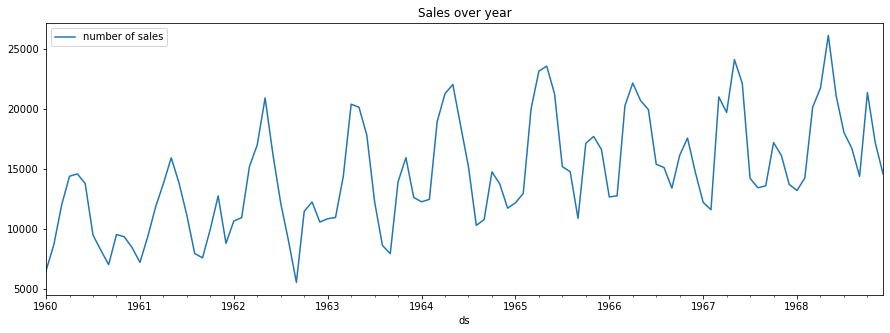

In [6]:
df.plot(x='ds', y='y', figsize=(15, 5), title='Sales over year', label='number of sales')

Первое приближение -  модель без учёта месячной сезонности

In [7]:
pred_model = Prophet()

In [8]:
# train model
train_periods = 12
train_df = df[:-train_periods]

pred_model.fit(train_df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -104.85
Iteration  1. Log joint probability =    72.7915. Improved by 177.641.
Iteration  2. Log joint probability =     141.49. Improved by 68.6982.
Iteration  3. Log joint probability =    148.523. Improved by 7.03351.
Iteration  4. Log joint probability =    148.546. Improved by 0.0223531.
Iteration  5. Log joint probability =    148.554. Improved by 0.00880483.
Iteration  6. Log joint probability =    148.576. Improved by 0.0214036.
Iteration  7. Log joint probability =    148.585. Improved by 0.00973269.
Iteration  8. Log joint probability =    148.606. Improved by 0.0204538.
Iteration  9. Log joint probability =    148.617. Improved by 0.0106609.
Iteration 10. Log joint probability =    148.636. Improved by 0.0195037.
Iteration 11. Log joint probability =    148.648. Improved by 0.0115894.
Iteration 12. Log joint probability =    148.666. Improved by 0.0185532.
Iteration 13. Log joint probability =    148.679. Improved by 0.0125183.
Iteration 14. 

In [9]:
future_forecast = pred_model.make_future_dataframe(periods=train_periods, freq='M')

In [10]:
forecast = pred_model.predict(future_forecast)

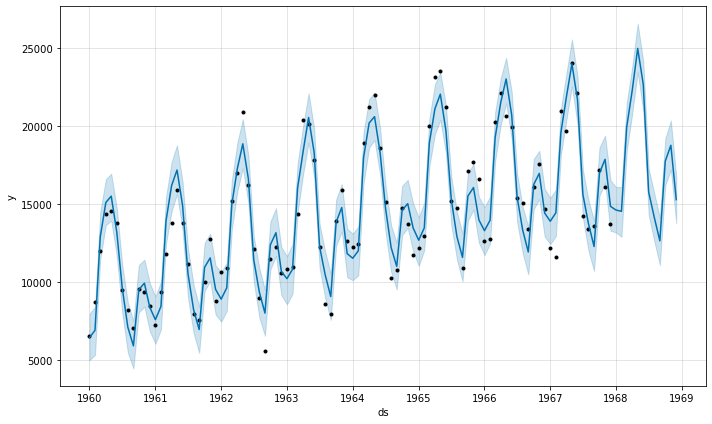

In [11]:
pred_model.plot(forecast);

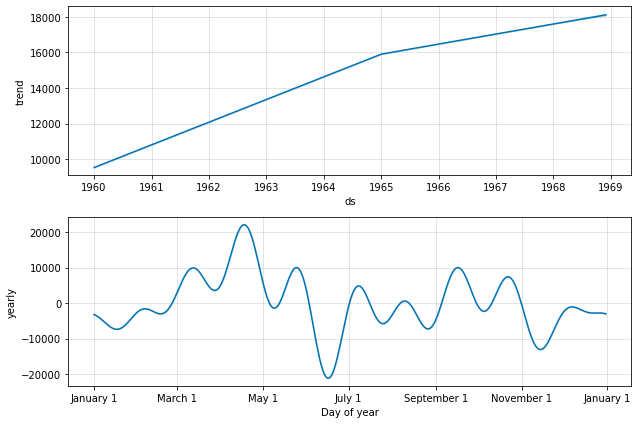

In [12]:
pred_model.plot_components(forecast);

In [13]:
check_df = forecast[-train_periods:][['yhat']].join(df[-train_periods:][['y']])

In [14]:
check_df = check_df.eval('e = abs(yhat - y)')\
    .eval('p = 100 * (e / y)')

In [15]:
print(f'Средняя абсолютная ошибка = {check_df.e.mean()}')
print(f'Средняя относительная ошибка = {check_df.p.mean()}')

Средняя абсолютная ошибка = 1470.9995492551327
Средняя относительная ошибка = 8.267394406496434


Второе приближение - учёт сезонности

In [16]:
prophet_with_seasonality = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_with_seasonality.add_seasonality(name='monthly', period=30.5, fourier_order=1)

In [17]:
prophet_with_seasonality.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -130.622


Iteration  1. Log joint probability =    77.1566. Improved by 207.778.
Iteration  2. Log joint probability =    133.574. Improved by 56.4178.
Iteration  3. Log joint probability =    174.543. Improved by 40.9688.
Iteration  4. Log joint probability =    216.747. Improved by 42.204.
Iteration  5. Log joint probability =    227.534. Improved by 10.7868.
Iteration  6. Log joint probability =    227.539. Improved by 0.00465344.
Iteration  7. Log joint probability =    227.549. Improved by 0.0103335.
Iteration  8. Log joint probability =    233.928. Improved by 6.37888.
Iteration  9. Log joint probability =    234.396. Improved by 0.468133.
Iteration 10. Log joint probability =    234.866. Improved by 0.470182.
Iteration 11. Log joint probability =    234.953. Improved by 0.0864569.
Iteration 12. Log joint probability =    235.041. Improved by 0.0887826.
Iteration 13. Log joint probability =     235.05. Improved by 0.00828943.
Iteration 14. Log joint probability =    235.315. Improved by 0.

In [18]:
future_forecast_s = prophet_with_seasonality.make_future_dataframe(periods=train_periods, freq='M')

In [19]:
forecast_s = prophet_with_seasonality.predict(future_forecast_s)

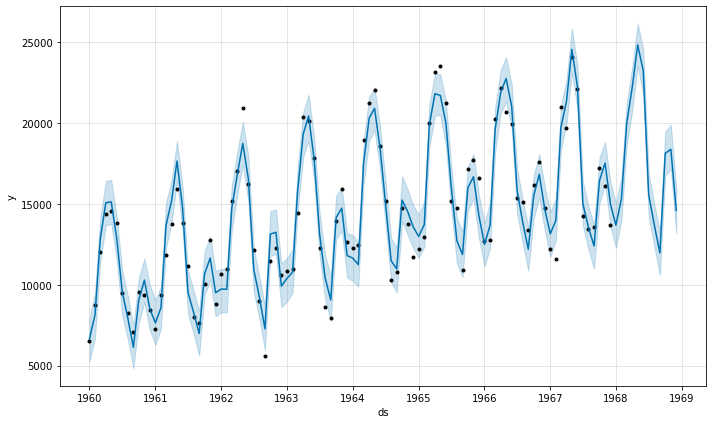

In [20]:
prophet_with_seasonality.plot(forecast_s);

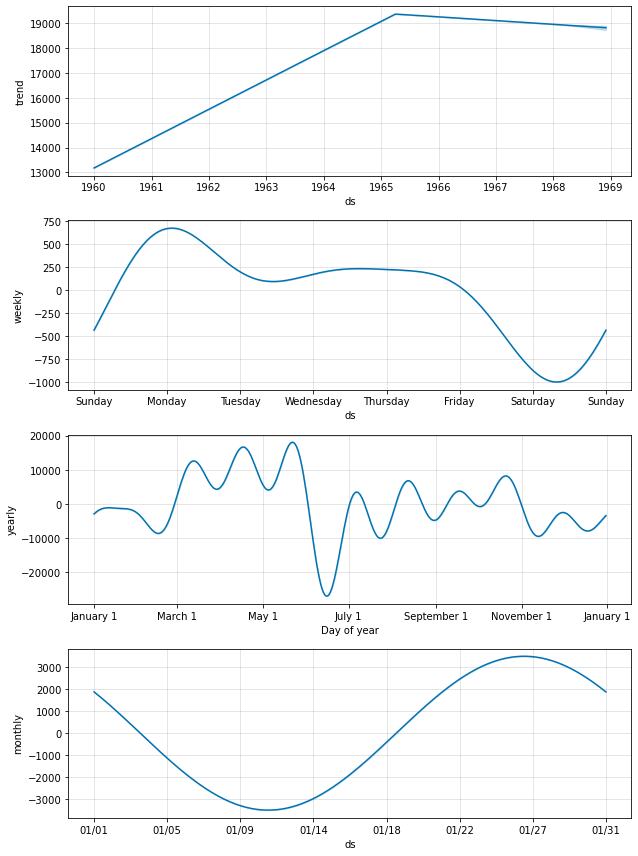

In [21]:
prophet_with_seasonality.plot_components(forecast_s);

In [22]:
check_season_df = forecast_s[-train_periods:][['yhat']].join(df[-train_periods:][['y']])

In [23]:
check_season_df = check_season_df.eval('e = abs(yhat - y)')\
    .eval('p = 100 * (e / y)')

In [24]:
print(f'Средняя абсолютная ошибка = {check_season_df.e.mean()}')
print(f'Средняя относительная ошибка = {check_season_df.p.mean()}')

Средняя абсолютная ошибка = 1492.849283066642
Средняя относительная ошибка = 8.309478717644996


In [25]:
plot_plotly(prophet_with_seasonality, forecast_s)

In [26]:
plot_components_plotly(prophet_with_seasonality, forecast_s)

In [27]:
df_cv = cross_validation(model=prophet_with_seasonality, initial='5 MS', period='1 MS', horizon='1 MS')

INFO:prophet:Making 95 forecasts with cutoffs between 1960-01-31 23:59:59.999000 and 1967-11-30 23:59:59.999000
  0%|          | 0/95 [00:00<?, ?it/s]

Exception: Less than two datapoints before cutoff. Increase initial window.